# Demonstration of bearing diagnosis with an outer race fault

In [36]:
import numpy as np
import scipy.io
from scipy.interpolate import interp1d, UnivariateSpline
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import hilbert

In [37]:
# Load data
mat_contents = scipy.io.loadmat('D:\data\work_with_Eric\Signal processing for CBM - a tutorial\demo_bearing_diagnosis.mat')
dt = mat_contents['dt'][0][0]
sigs_faulty_t = np.array(mat_contents['sigs_faulty_t'].squeeze())
sigs_healthy_t = np.array(mat_contents['sigs_healthy_t'].squeeze())
speed_faulty_gear = np.array(mat_contents['speed_faulty_gear'].squeeze())
speed_faulty_bearing = np.array(mat_contents['speed_faulty_bearing'].squeeze())
speed_healthy_gear = np.array(mat_contents['speed_healthy_gear'].squeeze())
speed_healthy_bearing = np.array(mat_contents['speed_healthy_bearing'].squeeze())
bearing_specifications = mat_contents['bearing_specifications']


bearing_specifications = [bearing_specifications['num_balls'][0][0][0][0], bearing_specifications['ball_diameter'][0][0][0][0],
                          bearing_specifications['pitch_diameter'][0][0][0][0], bearing_specifications['bearing_contact_angle'][0][0][0][0]]

In [38]:
def angular_resampling(t, speed, sig_t):
    # Time resolution
    dt = t[1] - t[0]
    
    # Calculate cumulative phase of the shaft
    cumulative_phase = np.cumsum(speed * dt)
    cumulative_phase -= cumulative_phase[0]

    # Sampling rate in the cycle domain after angular resampling
    cyc_fs = int(1 / (dt * min(speed)))
    
    # Generate constant phase intervals
    constant_phase_intervals = np.linspace(0, max(cumulative_phase), int(cyc_fs * max(cumulative_phase)))
    
    # Interpolate to find new time points with constant phase intervals
    interp_func = interp1d(cumulative_phase, t, kind='linear')
    times_of_constant_phase_intervals = interp_func(constant_phase_intervals)
    
    # Use UnivariateSpline for spline interpolation
    spline_interpolator = UnivariateSpline(t, sig_t, s=0)  # s=0 means no smoothing
    sig_cyc = spline_interpolator(times_of_constant_phase_intervals)

    # Sample points for optional resampling back to the time domain
    sample_pnts = {
        'times_of_constant_time_intervals': t,
        'times_of_constant_phase_intervals': times_of_constant_phase_intervals
    }

    return sig_cyc, cyc_fs, sample_pnts


def calc_sa(sig_cyc, sa_len):
    # Calculate the synchronous average.
    
    num_sgmnts = len(sig_cyc) // sa_len
    sig_cyc = sig_cyc[:num_sgmnts * sa_len]
    sigs_mtrx = np.reshape(sig_cyc, (sa_len, num_sgmnts), order='F')  # MATLAB uses Fortran-style column-major order

    sa = np.mean(sigs_mtrx, axis=1)

    return sa


def calc_difference_signal(sa, gear_mesh, num_sidebands):
    # Synchronous average length
    sa_len = len(sa)
    
    # Maximum order
    max_order = sa_len // 2
    
    # Find the order values to remove
    orders_2_remove = []
    num_of_gear_mesh_harmonics = max_order // gear_mesh
    for ii in range(1, num_of_gear_mesh_harmonics + 1):
        gear_mesh_harmonic_order = gear_mesh * ii
        orders_2_remove += list(range(gear_mesh_harmonic_order - num_sidebands, gear_mesh_harmonic_order + num_sidebands + 1))

    # Remove orders that exceed the maximum order
    orders_2_remove = [order for order in orders_2_remove if order <= max_order]
    orders_2_remove_positive_inds = np.array(orders_2_remove) + 1
    orders_2_remove_negative_inds = sa_len - orders_2_remove_positive_inds + 2
    orders_2_remove_inds = np.sort(np.concatenate([orders_2_remove_positive_inds, orders_2_remove_negative_inds]))

    # Convert from cycle to order
    sa_order = fft(sa, sa_len)

    # Set orders to remove to zero
    sa_order[orders_2_remove_inds] = 0

    # Convert from order to cycle
    difference_sig = np.real(ifft(sa_order, sa_len))

    return difference_sig


def dephase(t, speed, sig_t, num_of_fllwing_sgmnts_2_average):
    # angular resampling
    sig_cyc, cyc_fs, sample_pnts = angular_resampling(t, speed, sig_t)

    sa_len = cyc_fs  # number of points in the synchronous average
    sgmnt_len = sa_len * num_of_fllwing_sgmnts_2_average  # length of the averaged segment
    sig_cyc_after_dephase = np.zeros_like(sig_cyc)
    
    for long_sgmnt_num in range(1, int(np.ceil(len(sig_cyc) / sgmnt_len)) + 1):
        # separation to segments
        first_ind = (long_sgmnt_num - 1) * sgmnt_len
        last_ind = long_sgmnt_num * sgmnt_len
        
        if last_ind > len(sig_cyc):
            last_ind = len(sig_cyc)
            first_ind = len(sig_cyc) - sgmnt_len
        
        sgmnt = sig_cyc[first_ind:last_ind]
        
        # synchronous average
        sa = calc_sa(sgmnt, sa_len)

        # concatenation
        concatenated_sa = np.tile(sa, (num_of_fllwing_sgmnts_2_average))

        # subtraction
        subtracted_sgmnt = sig_cyc[first_ind:last_ind] - concatenated_sa

        # assembly of the segments
        sig_cyc_after_dephase[first_ind:last_ind] = subtracted_sgmnt

    # Convert back from the cycle domain to the time domain
    spline_interpolator = UnivariateSpline(sample_pnts['times_of_constant_phase_intervals'], sig_cyc_after_dephase, s=0)  # s=0 means no smoothing
    sig_t_after_dephase = spline_interpolator(sample_pnts['times_of_constant_time_intervals'])

    return sig_t_after_dephase


def calc_bearing_tones(shaft_speed, number_rolling_elements, rolling_element_diameter, pitch_diameter, bearing_contact_angle):
    coeff_1 = shaft_speed / 2
    coeff_2 = (rolling_element_diameter / pitch_diameter) * np.cos(bearing_contact_angle)

    ftf = coeff_1 * (1 - coeff_2)
    bsf = (pitch_diameter / rolling_element_diameter) * coeff_1 * (1 - coeff_2**2)
    bpfo = number_rolling_elements * coeff_1 * (1 - coeff_2)
    bpfi = number_rolling_elements * coeff_1 * (1 + coeff_2)

    return ftf, bsf, bpfo, bpfi


def extract_specific_bearing_tone(dorder, bearing_sig_env_order, order_of_the_bearing_tone, order_sensitivity):

    sig = np.abs(bearing_sig_env_order)

    low_ind = int(np.floor((1 - order_sensitivity) * order_of_the_bearing_tone / dorder))
    high_ind = int(np.ceil((1 + order_sensitivity) * order_of_the_bearing_tone / dorder))

    extracted_bearing_tone = np.max(sig[low_ind:high_ind])

    return extracted_bearing_tone

In [39]:
# Processing of the healthy signals
num_healthy_sigs = sigs_healthy_t.shape[1] # number of healthy signals
healthy_ftf_values = np.zeros(num_healthy_sigs)
hi_ftf_healthy_vctr = np.zeros(num_healthy_sigs)
healthy_bsf_values = np.zeros(num_healthy_sigs)
hi_bsf_healthy_vctr = np.zeros(num_healthy_sigs)
healthy_bpfo_values = np.zeros(num_healthy_sigs)
hi_bpfo_healthy_vctr = np.zeros(num_healthy_sigs)
healthy_bpfi_values = np.zeros(num_healthy_sigs)
hi_bpfi_healthy_vctr = np.zeros(num_healthy_sigs)

for sig_num in range(num_healthy_sigs):
    sig_healthy_t = sigs_healthy_t[:, sig_num]
    speed_healthy_gear_t = speed_healthy_gear[:, sig_num]
    speed_healthy_bearing_t = speed_healthy_bearing[:, sig_num]
    t = np.arange(0, len(sig_healthy_t) * dt, dt)

    # Dephase
    num_of_fllwing_sgmnts_2_average = 20
    sig_after_dephase = dephase(t, speed_healthy_gear_t, sig_healthy_t, num_of_fllwing_sgmnts_2_average)

    # Angular resampling
    sig_cyc, cyc_fs, sample_pnts = angular_resampling(t, speed_healthy_bearing_t, sig_after_dephase)
    dcyc = 1 / cyc_fs

    # Envelope calculation
    sig_env_cyc = np.abs(np.square(np.abs(hilbert(sig_cyc))))

    # Convert envelope from cycle domain to order domain
    sig_env_order = np.fft.fft(sig_env_cyc)
    dorder = 1 / (len(sig_env_cyc) * dcyc)

    # Features extraction
    shaft_speed = 1
    ftf, bsf, bpfo, bpfi = calc_bearing_tones(shaft_speed, bearing_specifications[0],
                                              bearing_specifications[1], 
                                              bearing_specifications[2],
                                              bearing_specifications[3])
    bearing_tones = [ftf, bsf, bpfo, bpfi]
    order_sensitivity = 0.02 # sensitivity of the order value for searching the bearing tone pick
    first_ftf_value = extract_specific_bearing_tone(dorder, sig_env_order, ftf, order_sensitivity)
    first_bsf_value = extract_specific_bearing_tone(dorder, sig_env_order, bsf, order_sensitivity)
    first_bpfo_value = extract_specific_bearing_tone(dorder, sig_env_order, bpfo, order_sensitivity)
    first_bpfi_value = extract_specific_bearing_tone(dorder, sig_env_order, bpfi, order_sensitivity)

    healthy_ftf_values[sig_num] = first_ftf_value
    healthy_bsf_values[sig_num] = first_bsf_value
    healthy_bpfo_values[sig_num] = first_bpfo_value
    healthy_bpfi_values[sig_num] = first_bpfi_value

healthy_ftf_average = np.mean(healthy_ftf_values)
healthy_ftf_std = np.std(healthy_ftf_values)
healthy_bsf_average = np.mean(healthy_bsf_values)
healthy_bsf_std = np.std(healthy_bsf_values)
healthy_bpfo_average = np.mean(healthy_bpfo_values)
healthy_bpfo_std = np.std(healthy_bpfo_values)
healthy_bpfi_average = np.mean(healthy_bpfi_values)
healthy_bpfi_std = np.std(healthy_bpfi_values)

# Health Indicator (HI) calculation for healthy signals
hi_ftf_healthy_vctr = np.abs((healthy_ftf_values - healthy_ftf_average) / healthy_ftf_std)
hi_bsf_healthy_vctr = np.abs((healthy_bsf_values - healthy_bsf_average) / healthy_bsf_std)
hi_bpfo_healthy_vctr = np.abs((healthy_bpfo_values - healthy_bpfo_average) / healthy_bpfo_std)
hi_bpfi_healthy_vctr = np.abs((healthy_bpfi_values - healthy_bpfi_average) / healthy_bpfi_std)

In [40]:
# Processing of the faulty signals
num_faulty_sigs = sigs_faulty_t.shape[1]
hi_ftf_faulty_vctr = np.zeros(num_faulty_sigs)
hi_bsf_faulty_vctr = np.zeros(num_faulty_sigs)
hi_bpfo_faulty_vctr = np.zeros(num_faulty_sigs)
hi_bpfi_faulty_vctr = np.zeros(num_faulty_sigs)

for sig_num in range(num_faulty_sigs):
    sig_faulty_t = sigs_faulty_t[:, sig_num]
    speed_faulty_gear_t = speed_faulty_gear[:, sig_num]
    speed_faulty_bearing_t = speed_faulty_bearing[:, sig_num]
    t = np.arange(0, len(sig_faulty_t) * dt, dt)

    # Dephase
    num_of_fllwing_sgmnts_2_average = 20
    sig_after_dephase = dephase(t, speed_faulty_gear_t, sig_faulty_t, num_of_fllwing_sgmnts_2_average)

    # Angular resampling
    sig_cyc, cyc_fs, sample_pnts = angular_resampling(t, speed_faulty_bearing_t, sig_after_dephase)
    dcyc = 1 / cyc_fs

    # Envelope calculation
    sig_env_cyc = np.abs(np.square(np.abs(hilbert(sig_cyc))))

    # Convert envelope from cycle domain to order domain
    sig_env_order = np.fft.fft(sig_env_cyc)
    dorder = 1 / (len(sig_env_cyc) * dcyc)

    # Features extraction
    shaft_speed = 1
    ftf, bsf, bpfo, bpfi = calc_bearing_tones(shaft_speed, bearing_specifications[0],
                                              bearing_specifications[1], 
                                              bearing_specifications[2],
                                              bearing_specifications[3])
    bearing_tones = [ftf, bsf, bpfo, bpfi]
    order_sensitivity = 0.02 # sensitivity of the order value for searching the bearing tone pick
    first_ftf_value = extract_specific_bearing_tone(dorder, sig_env_order, ftf, order_sensitivity)
    first_bsf_value = extract_specific_bearing_tone(dorder, sig_env_order, bsf, order_sensitivity)
    first_bpfo_value = extract_specific_bearing_tone(dorder, sig_env_order, bpfo, order_sensitivity)
    first_bpfi_value = extract_specific_bearing_tone(dorder, sig_env_order, bpfi, order_sensitivity)

    # HI calculation
    hi_ftf_faulty_vctr[sig_num] = np.abs((first_ftf_value - healthy_ftf_average) / healthy_ftf_std).mean()
    hi_bsf_faulty_vctr[sig_num] = np.abs((first_bsf_value - healthy_bsf_average) / healthy_bsf_std).mean()
    hi_bpfo_faulty_vctr[sig_num] = np.abs((first_bpfo_value - healthy_bpfo_average) / healthy_bpfo_std).mean()
    hi_bpfi_faulty_vctr[sig_num] = np.abs((first_bpfi_value - healthy_bpfi_average) / healthy_bpfi_std).mean()

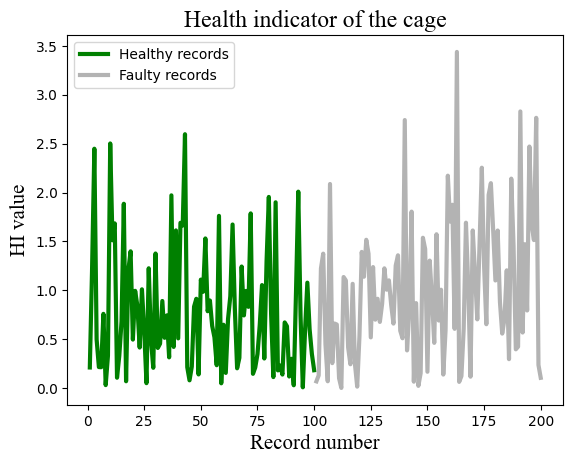

In [42]:
# Part for figures
axis_font_size = 10
title_font_size = 17
axis_name_font_size = 15
lgnd_font_size = 10

plt.figure()
plt.plot(range(1, num_healthy_sigs + 1), hi_ftf_healthy_vctr, linewidth=3, color='g')
plt.plot(range(num_healthy_sigs + 1, num_healthy_sigs + num_faulty_sigs + 1), hi_ftf_faulty_vctr, linewidth=3, color=[0.7, 0.7, 0.7])
plt.title('Health indicator of the cage', fontname='Times New Roman', fontsize=title_font_size)
plt.xlabel('Record number', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.ylabel('HI value', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.legend(['Healthy records', 'Faulty records'], loc='upper left', prop={'size': lgnd_font_size})
plt.show()

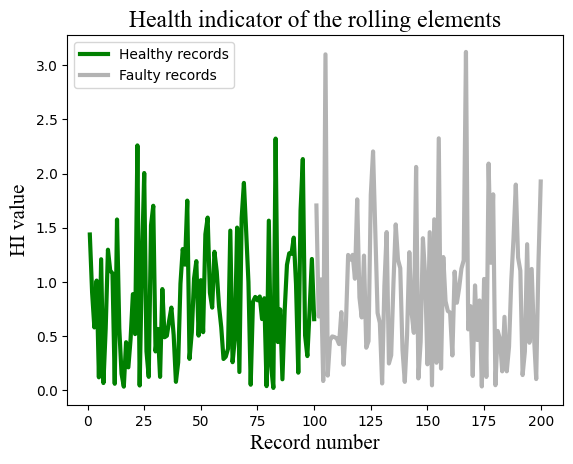

In [43]:
plt.figure()
plt.plot(range(1, num_healthy_sigs + 1), hi_bsf_healthy_vctr, linewidth=3, color='g')
plt.plot(range(num_healthy_sigs + 1, num_healthy_sigs + num_faulty_sigs + 1), hi_bsf_faulty_vctr, linewidth=3, color=[0.7, 0.7, 0.7])
plt.title('Health indicator of the rolling elements', fontname='Times New Roman', fontsize=title_font_size)
plt.xlabel('Record number', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.ylabel('HI value', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.legend(['Healthy records', 'Faulty records'], loc='upper left', prop={'size': lgnd_font_size})
plt.show()

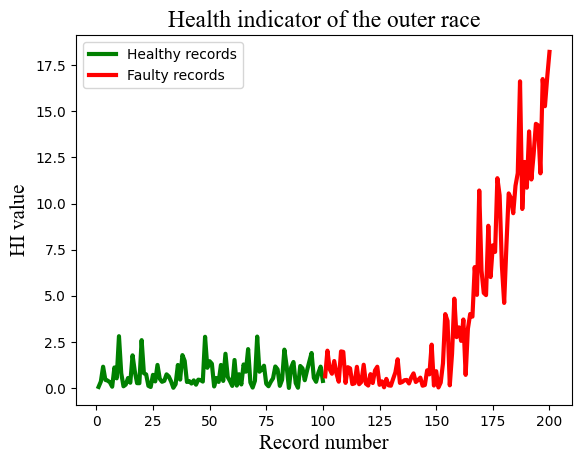

In [44]:
plt.figure()
plt.plot(range(1, num_healthy_sigs + 1), hi_bpfo_healthy_vctr, linewidth=3, color='g')
plt.plot(range(num_healthy_sigs + 1, num_healthy_sigs + num_faulty_sigs + 1), hi_bpfo_faulty_vctr, linewidth=3, color='r')
plt.title('Health indicator of the outer race', fontname='Times New Roman', fontsize=title_font_size)
plt.xlabel('Record number', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.ylabel('HI value', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.legend(['Healthy records', 'Faulty records'], loc='upper left', prop={'size': lgnd_font_size})
plt.show()

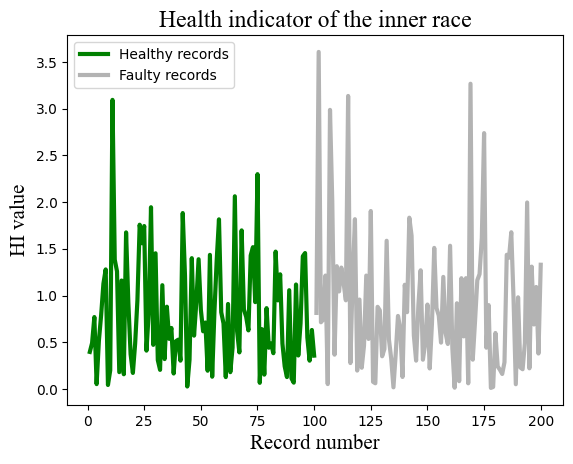

In [45]:
plt.figure()
plt.plot(range(1, num_healthy_sigs + 1), hi_bpfi_healthy_vctr, linewidth=3, color='g')
plt.plot(range(num_healthy_sigs + 1, num_healthy_sigs + num_faulty_sigs + 1), hi_bpfi_faulty_vctr, linewidth=3, color=[0.7, 0.7, 0.7])
plt.title('Health indicator of the inner race', fontname='Times New Roman', fontsize=title_font_size)
plt.xlabel('Record number', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.ylabel('HI value', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.legend(['Healthy records', 'Faulty records'], loc='upper left', prop={'size': lgnd_font_size})
plt.show()